### 볼린저 밴드 투자 전략 
1. 이동 평균선 : 데이터의 20개의 평균값
2. 상단 밴드 : 이동 평균선 + (2 * 20개의 데이터의 표준편차)
3. 하단 밴드 : 이동 평균선 - (2 * 20개의 데이터의 표준편차)
4. 매수 타이밍 : 하단 밴드보다 이하로 가격이 떨어졌을때
5. 매도 타이밍 : 상단 밴드보다 이상으로 가격이 올랐을때

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
df = pd.read_csv("../csv/MSFT.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.069996,1031788800
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.072496,308160000
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.073746,133171200
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.071871,67766400
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.070621,47894400


In [3]:
# 데이터프레임의 정보 확인 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8389 entries, 0 to 8388
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       8389 non-null   object 
 1   Open       8389 non-null   float64
 2   High       8389 non-null   float64
 3   Low        8389 non-null   float64
 4   Close      8389 non-null   float64
 5   Adj Close  8389 non-null   float64
 6   Volume     8389 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 458.9+ KB


In [4]:
# Date 컬럼의 데이터를 시계열로 변경하고 인덱스 설정
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [5]:
# 결측치, 양의 무한대, 음의 무한대를 제외
flag = df.isin( [np.nan, np.inf, -np.inf] ).any(axis=1)
df = df.loc[~flag, ['Adj Close']]

In [6]:
df

,Adj Close
Date,
1986-03-13,0.069996
1986-03-14,0.072496
1986-03-17,0.073746
1986-03-18,0.071871
1986-03-19,0.070621
...,...
2019-06-18,135.160004
2019-06-19,135.690002
2019-06-20,136.949997


In [7]:
df.head()

,Adj Close
Date,
1986-03-13,0.069996
1986-03-14,0.072496
1986-03-17,0.073746
1986-03-18,0.071871
1986-03-19,0.070621


In [8]:
# 이동 평균선 생성
# 20개의 데이터의 평균 값
df.iloc[0:20].mean()

Adj Close    0.069246
dtype: float64

In [9]:
df2 = df.copy()

In [10]:
df2['center'] = np.nan

In [11]:
for i in range(20, len(df2-1)):
    mean_data = df2.iloc[i-20:i,0].mean()
    # 평균값을 i번째 인덱스에 두 번째 컬럼(1)에 대입
    df2.iloc[i-1,1] = mean_data
df2

,Adj Close,center
Date,,
1986-03-13,0.069996,NaN
1986-03-14,0.072496,NaN
1986-03-17,0.073746,NaN
1986-03-18,0.071871,NaN
1986-03-19,0.070621,NaN
...,...,...
2019-06-18,135.160004,128.226002
2019-06-19,135.690002,128.665502
2019-06-20,136.949997,129.129502


In [12]:
# rolling(n) : n만큼 데이터를 그룹화
df['center'] = df['Adj Close'].rolling(20).mean()

In [13]:
df.iloc[18:22]

,Adj Close,center
Date,,
1986-04-09,0.069996,NaN
1986-04-10,0.070621,0.069246
1986-04-11,0.071871,0.069340
1986-04-14,0.072496,0.069340


In [14]:
# 상단 밴드 생성
df['up'] = df['center'] + (2 * df['Adj Close'].rolling(20).std())

In [15]:
# 하단 밴드 생성
df['down'] = df['center'] - (2 * df['Adj Close'].rolling(20).std())

In [16]:
df_test = df.tail(100)

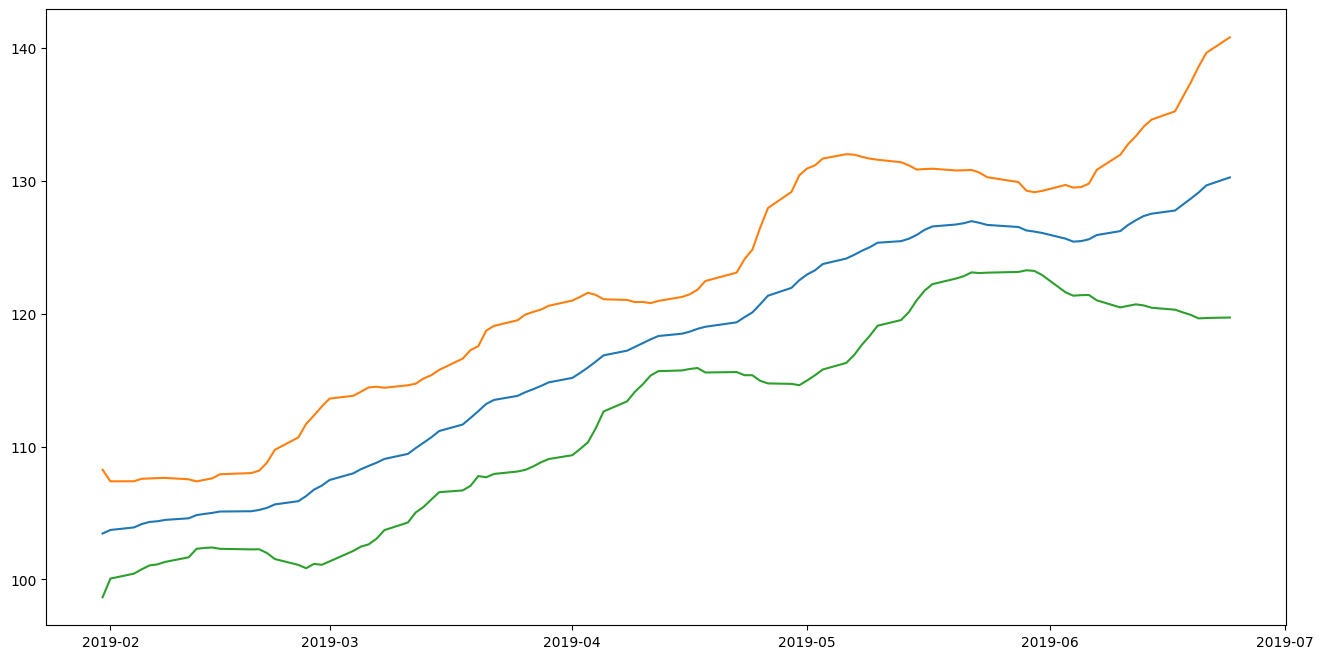

In [17]:
# 20일 이평선과
# 볼린져 밴드 생성 그래프
x = df_test.index
center_price = df_test['center']
up_price = df_test['up']
down_price = df_test['down']

plt.figure(figsize=(16,8))
plt.plot(x, center_price)
plt.plot(x, up_price)
plt.plot(x, down_price)

plt.show()

<Axes: xlabel='Date'>

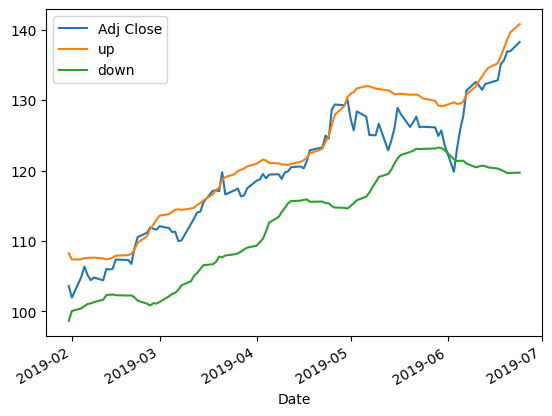

In [18]:
# 20일 이평선과 과거 실제 종가 데이터
df_test[['Adj Close', 'up','down']].plot()

In [19]:
# 원하는 시작 지점부터 그래프 생성하기
start = '2010-01-01'

In [20]:
start = datetime.strptime(start,'%Y-%m-%d')

In [21]:
price_df = df.loc[start:]

### 보유 내역 추가
- 조건식
    - 상단 밴드보다 수정 종가가 높거나 같은 경우 
        - 현재 보유 상태라면?
            - 매도(trade='')
        - 현재 보유 상태가 아니면?
            - 유지(trade = '')
    - 상단 밴드보다 낮고, 하단 밴드보다 높은 경우
        - 현재 보유 상태라면?
            - 유지(trade='buy')
        - 현재 보유 상태가 아니면?
            - 유지(trade='')
    - 하단밴드보다 수정 종가가 낮거나 같은 경우
        - 현재 보유 상태라면?
            - 유지(trade='buy')
        - 보유 상태가 아니면?
            - 매수(trade='')

In [22]:
# trade 컬럼 생성
price_df['trade'] = ''

C:\Users\Owner\AppData\Local\Temp\ipykernel_34156\3496652659.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_df['trade'] = ''


In [23]:
price_df.head(3)

,Adj Close,center,up,down,trade
Date,,,,,
2010-01-04,24.525019,24.056307,24.964478,23.148135,
2010-01-05,24.532942,24.095134,25.015633,23.174635,
2010-01-06,24.382378,24.133962,25.032815,23.235109,


In [24]:
for idx in price_df.index:
    # idx에는 price_df의 인덱스 값(시계열 데이터)
    # 상단 밴드의 값보다 수정 종가의 값이 크거나 같다면
    if price_df.loc[idx, 'Adj Close'] >= price_df.loc[idx,'up']:
        # 현재 보유 상태라면? -> 전날의 trade가 'buy'인 경우
        if price_df.shift().loc[idx,'trade'] == 'buy':
            price_df.loc[idx,'trade'] =''
        # 현재 보유상태가 아니라면
        else:
            price_df.loc[idx,'trade'] =''
            
            
    # 하단 밴드보다 낮거나 같다면?
    elif price_df.loc[idx,'Adj Close'] <= price_df.loc[idx,'down']:
        # 현재 보유 상태라면? -> 전날의 trade가 'buy'인 경우 -> 유지
        if price_df.shift().loc[idx,'trade'] == 'buy':
            price_df.loc[idx,'trade'] = 'buy'
        else:
            price_df.loc[idx,'trade'] = 'buy'
            
            
    # 수정 종가가 밴드 사이에 있을 때
    else:
        # 현재 보유 상태라면?-> 유지
        if price_df.shift().loc[idx,'trade'] == 'buy':
            price_df.loc[idx,'trade'] = 'buy'
        else:
            price_df.loc[idx,'trade'] = ''

In [25]:
price_df['trade'].value_counts()

trade
       1400
buy     984
Name: count, dtype: int64

### 수익률 계산
- 구매한 날의 수정 종가
    - 전날의 trade가 ''이고, 오늘의 trade가 'buy'인 조건의 Adj Close
- 판매한 날의 수정 종가
    - 전날의 trade가 'buy'이고, 오늘의 trade가 ''인 조건의 Adj Close
- 수익율
    - 판매한 날의 수정 종가 / 구매한 날의 수정 종가

In [26]:
# 수익률 컬럼 생성
price_df['rtn'] = 1

C:\Users\Owner\AppData\Local\Temp\ipykernel_34156\1178645707.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_df['rtn'] = 1


In [27]:
for idx in price_df.index:
    if(price_df.shift().loc[idx,'trade'] == '') & (price_df.loc[idx,'trade']=='buy'):
        buy = price_df.loc[idx,'Adj Close']
        print(f'매수일 : {idx}, 매수한 가격 : {buy}')
    elif(price_df.shift().loc[idx,'trade'] == 'buy') & (price_df.loc[idx,'trade']==''):
        sell = price_df.loc[idx,'Adj Close']
        print(f'매도일 : {idx}, 매도한 가격 : {sell}')
        rtn = sell/buy
        price_df.loc[idx,'rtn'] = rtn
        print(f'수익률은 : {rtn}')

C:\Users\Owner\AppData\Local\Temp\ipykernel_34156\3792186152.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.0279195322598862' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  price_df.loc[idx,'rtn'] = rtn


매수일 : 2010-01-22 00:00:00, 매수한 가격 : 22.948128
매도일 : 2010-03-17 00:00:00, 매도한 가격 : 23.588829
수익률은 : 1.0279195322598862
매수일 : 2010-05-06 00:00:00, 매수한 가격 : 23.07136
매도일 : 2010-09-13 00:00:00, 매도한 가격 : 20.187721
수익률은 : 0.875012179602763
매수일 : 2010-11-23 00:00:00, 매수한 가격 : 20.319853
매도일 : 2011-01-06 00:00:00, 매도한 가격 : 23.312819
수익률은 : 1.1472926994107686
매수일 : 2011-03-16 00:00:00, 매수한 가격 : 20.171436
매도일 : 2011-04-06 00:00:00, 매도한 가격 : 21.278055
수익률은 : 1.0548606950937949
매수일 : 2011-05-16 00:00:00, 매수한 가격 : 19.992422
매도일 : 2011-06-27 00:00:00, 매도한 가격 : 20.639456
수익률은 : 1.032363962705469
매수일 : 2011-08-04 00:00:00, 매수한 가격 : 21.245531
매도일 : 2011-08-31 00:00:00, 매도한 가격 : 21.923595
수익률은 : 1.0319156061573607
매수일 : 2011-11-01 00:00:00, 매수한 가격 : 21.420837
매도일 : 2012-01-03 00:00:00, 매도한 가격 : 22.229851
수익률은 : 1.037767618510892
매수일 : 2012-04-04 00:00:00, 매수한 가격 : 26.087456
매도일 : 2012-06-19 00:00:00, 매도한 가격 : 25.829544
수익률은 : 0.9901135626256542
매수일 : 2012-07-12 00:00:00, 매수한 가격 : 24.087934
매도일 : 2012-09-

In [28]:
price_df.head(3)

,Adj Close,center,up,down,trade,rtn
Date,,,,,,
2010-01-04,24.525019,24.056307,24.964478,23.148135,,1.0
2010-01-05,24.532942,24.095134,25.015633,23.174635,,1.0
2010-01-06,24.382378,24.133962,25.032815,23.235109,,1.0


In [29]:
acc_rtn = 1

for idx in price_df.index:
    acc_rtn *= price_df.loc[idx,'rtn']
acc_rtn

np.float64(2.985057953026086)

In [30]:
# 누적 수익률 계산
price_df['rtn'].cumprod()

Date
2010-01-04    1.000000
2010-01-05    1.000000
2010-01-06    1.000000
2010-01-07    1.000000
2010-01-08    1.000000
                ...   
2019-06-18    2.985058
2019-06-19    2.985058
2019-06-20    2.985058
2019-06-21    2.985058
2019-06-24    2.985058
Name: rtn, Length: 2384, dtype: float64

#### 볼린저 밴드의 함수화
1. 첫번째 함수
    - 밴드를 생성하는 함수
        - 매개변수 5개
            - DataFrame
            - 기준이 되는 컬럼의 이름 ('Adj Close')
            - 시작 시간 ('2010-01-01')
            - 종료 시간 (현재 시간)
            - 볼린저 밴드의 그룹이 되는 데이터의 개수 (20) 며칠 평균선?
        - 데이터 프레임에 컬럼 중 Date가 존재하는가?
            - 존재한다면 Date 컬럼을 인덱스로 변경
        - index를 시계열 데이터로 변경
        - 결측치와 무한대 값을 제외
        - 기준이 되는 컬럼을 제외하고 모두 삭제
        - 이평선, 상단밴드, 하단 밴드 컬럼 생성
        - 시작 시간과 종료 시간을 기준으로 필터링
        - 위에서 작업 한 결과를 되돌려준다.

In [31]:
def create_band(_df,
                  _stdcol='Adj Close',
                  _start = '2010-01-01',
                  _end = datetime.now(),
                  _cnt = 20):
    result = _df.copy()
    # 데이터 프레임 중 date가 존재한다면 date를 인덱스로 재설정
    if 'Date' in result.columns:
        # 데이터 프레임의 인덱스 재설정
        result.set_index('Date',inplace=True)
    # index 타입을 datetime으로 변환
    result.index = pd.to_datetime(result.index)
        
    # 결측치와 무한대 값 제거
    flag = result.isin([np.nan,np.inf,-np.inf]).any(axis=1)
    result = result.loc[~flag, [_stdcol]] # 동시에 기준이 되는 컬럼을 제외한 나머지 컬럼 삭제
    
    #이평선 먼저 생성
    result['center'] = result[_stdcol].rolling(_cnt).mean()
    
    # 상단 밴드, 하단 밴드 컬럼 생성
    result['up'] = result['center'] + (2 * result[_stdcol].rolling(_cnt).std())
    result['down'] = result['center'] - (2 * result[_stdcol].rolling(_cnt).std())
    
    # 시작 시간과 종료 시간을 시계열ㄷ ㅔ이터로 변경
    try :
        start = datetime.strptime(_start,'%Y-%m-%d')
        if type(_end) == 'str' :
            end = datetime.strptime(_end, '%Y-%m-%d')
        else:
            end = _end
    except:
        print('시작 시간과 종료 시간의 포멧은 YYYY-mm-dd입니다.')
        return ''
    
    result = result.loc[start: end]
    return result

In [32]:
df11 = pd.read_csv("../csv/MSFT.csv")
df11.head()


,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.069996,1031788800
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.072496,308160000
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.073746,133171200
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.071871,67766400
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.070621,47894400


In [33]:
create_band(df11)

,Adj Close,center,up,down
Date,,,,
2010-01-04,24.525019,24.056307,24.964478,23.148135
2010-01-05,24.532942,24.095134,25.015633,23.174635
2010-01-06,24.382378,24.133962,25.032815,23.235109
2010-01-07,24.128809,24.168828,25.004852,23.332803
2010-01-08,24.295214,24.206467,24.989876,23.423058
...,...,...,...,...
2019-06-18,135.160004,128.226002,136.343399,120.108604
2019-06-19,135.690002,128.665502,137.408349,119.922655
2019-06-20,136.949997,129.129502,138.604271,119.654733


2. 두번째 함수
- 트레이드 컬럼을 생성하는 함수
    - 매개변수 1 개 (create_band()함수의 결과)
- 복사본 생성
- 데이터프레임에서 첫번째 컬럼의 이름을 변수(col)에 저장
- trade 컬럼을 생성해서 '' 을 대입
- 보유 내역을 반복문을 이용하여 대입
- 해당 결과를 되돌려줌

In [34]:
def create_trade(_cb_result):
    # 복사본 생성
    df = _cb_result.copy()
    
    #데이터프레임에서 첫번째 컬럼 이름 col에 저장
    col = df.columns[0]
    # trade 컬럼 생성, ' ' 대입
    df['trade'] = ''
    for idx in df.index:
        # 상단 밴드보다 높은 가격일 때
        if df.loc[idx,col] >= df.loc[idx,'up']:
            # 현재 보유 상태라면?
            if df.shift().loc[idx,'trade'] == 'buy':
                df.loc[idx,'trade'] = ''
            else:
                df.loc[idx,'trade'] = ''
        
        # 하단 밴드보다 낮은 가격일 때
        elif df.loc[idx,col] <= df.loc[idx,'down']:
            if df.shift().loc[idx,'trade'] == 'buy':
                df.loc[idx,'trade'] = 'buy'
            else:
                df.loc[idx,'trade'] = 'buy'
        # 밴드 중간에 있을 때
        else:
            if df.shift().loc[idx,'trade'] == 'buy':
                df.loc[idx,'trade'] = 'buy'
            else:
                df.loc[idx,'trade'] = ''
    return df

In [35]:
create_trade(create_band(df11))['trade'].value_counts()

trade
       1400
buy     984
Name: count, dtype: int64

3. 세번째 함수
- 수익률을 계산하는 함수
    - 매개변수 1개 : create_trade() 함수의 결과
- 복사본 생성
- 컬럼의 첫 번째 이름을 변수(col)에 저장
- 수익율 컬럼 하나 생성하고 1 대입
- 매수인 경우, 매도인 경우를 찾아서 수익률 rtn에 대입
- 수익률 데이터를 기준으로 하여 누적 수익율 컬럼을 생성, 대입
- 생성된 데이터프레임과 최종 누적 수익율을 되돌려줌


In [36]:
def create_rtn(_df):
    result = _df.copy()
    
    col = result.columns[0]
    
    result['rtn'] = 1
    
    for idx in result.index:
        #매수일 
        if result.shift().loc[idx,'trade'] == '' and result.loc[idx,'trade'] =='buy':
            buy = result.loc[idx,col]
        #매도일
        elif result.shift().loc[idx,'trade'] =='buy' and result.loc[idx,'trade'] == '':
            sell = result.loc[idx,col]
            rtn = sell / buy
            result.loc[idx,'rtn'] = rtn
    # 누적 수익률
    result['acc_rtn'] = result['rtn'].cumprod()
    # 최종 누적 수익율 변수 저장
    acc_rtn = result.iloc[-1,-1]
    return result, acc_rtn

In [37]:
create_rtn(create_trade(create_band(df11)))[1]

C:\Users\Owner\AppData\Local\Temp\ipykernel_34156\849643288.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.0279195322598862' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  result.loc[idx,'rtn'] = rtn


np.float64(2.985057953026086)

In [38]:
create_rtn(create_trade(create_band(df11)))[0]

C:\Users\Owner\AppData\Local\Temp\ipykernel_34156\849643288.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.0279195322598862' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  result.loc[idx,'rtn'] = rtn


,Adj Close,center,up,down,trade,rtn,acc_rtn
Date,,,,,,,
2010-01-04,24.525019,24.056307,24.964478,23.148135,,1.0,1.000000
2010-01-05,24.532942,24.095134,25.015633,23.174635,,1.0,1.000000
2010-01-06,24.382378,24.133962,25.032815,23.235109,,1.0,1.000000
2010-01-07,24.128809,24.168828,25.004852,23.332803,,1.0,1.000000
2010-01-08,24.295214,24.206467,24.989876,23.423058,,1.0,1.000000
...,...,...,...,...,...,...,...
2019-06-18,135.160004,128.226002,136.343399,120.108604,,1.0,2.985058
2019-06-19,135.690002,128.665502,137.408349,119.922655,,1.0,2.985058
2019-06-20,136.949997,129.129502,138.604271,119.654733,,1.0,2.985058
